<a href="https://colab.research.google.com/github/adam-matic/KinematicCognition/blob/master/Purity%2C_scaling_and_optimality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Function definitions

In [0]:
from numpy import *
from matplotlib.pyplot import *
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.fftpack as fp
from numba import jit, njit
import pandas as pd
import scipy.stats as stats
from google.colab import files
import os
from cycler import cycler
from matplotlib import animation, rc
from matplotlib.patches import Polygon, Arrow, FancyArrowPatch as fap

class empty:
  pass

@njit
def generate_lebedev_trajectory(t, q_t, x0 = 0, y0 = 0, dx0 = 2, dy0 = -1, ddx0 = -1, ddy0 = 0, dt = 0.001):  
  N = len(t)
  x = zeros(N); dx = zeros(N); ddx = zeros(N)
  y = zeros(N); dy = zeros(N); ddy = zeros(N)
  x[0] = x0;   dx[0] = dx0;   ddx[0] = ddx0
  y[0] = y0;   dy[0] = dy0;   ddy[0] = ddy0
  for i in range(1, N):
    ddx[i] = ddx[i-1] - dt * dx[i-1] * q_t[i-1]
    dx[i] = dx[i-1] + dt * ddx[i]
    x[i] = x[i-1] + dt * dx[i]
    ddy[i] = ddy[i-1] - dt * dy[i-1] * q_t[i-1]
    dy[i] = dy[i-1] + dt * ddy[i]
    y[i] = y[i-1] + dt * dy[i]    
  return x, y, dx, dy, ddx, ddy

@jit
def get_pure_trajectory(x0=0, y0=0, eps=1.2, v=2, th0=1, N=2, scale=220, beta=2.0 / 3.0, k=2, dtheta = 0.001, dt = 0.001):
  theta = arange(th0, math.pi*N + th0, dtheta)
  thsub = theta - th0
  xs = x0 + cumsum(scale * dtheta * cos(theta) * exp(eps * sin(v * thsub)))
  ys = y0 + cumsum(scale * dtheta * sin(theta) * exp(eps * sin(v * thsub)))
  R_exp_beta = exp(beta * eps * sin(v * thsub))
  t_theta = cumsum(dtheta * R_exp_beta / k)
  new_time = arange(0, t_theta[-1], dt)
  xspl = interpolate.UnivariateSpline(t_theta, xs, k=3, s=0)
  yspl = interpolate.UnivariateSpline(t_theta, ys, k=3, s=0)
  xo = xspl(new_time)
  yo = yspl(new_time)
  return xo, yo, new_time

def butter_filter(x, y, cutoff, samples_per_s=200, filter_order = 2):
  B, A = signal.butter(filter_order, cutoff / (samples_per_s / 2), 'low')
  xs = signal.filtfilt(B, A, x)
  ys = signal.filtfilt(B, A, y)
  return xs, ys

def analyze(xs, ys, ts, dt=0.001, rlim=None):
  d = empty()
  xspl = interpolate.UnivariateSpline(ts, xs, k=3, s=0)
  yspl = interpolate.UnivariateSpline(ts, ys, k=3, s=0)
  d.t = arange(ts[0], ts[-1], dt)
  d.x = xspl(d.t)
  d.y = yspl(d.t)
  d.xvel = xspl.derivative(1)(d.t)
  d.yvel = yspl.derivative(1)(d.t)
  d.xacc = xspl.derivative(2)(d.t)
  d.yacc = yspl.derivative(2)(d.t)
  d.xjerk = xspl.derivative(3)(d.t)
  d.yjerk = yspl.derivative(3)(d.t)
  d.P = d.xvel * d.xacc + d.yvel * d.yacc
  d.J = sum(sqrt(d.xjerk**2 + d.yjerk**2)) * dt
  d.V = sqrt(d.xvel**2.0 + d.yvel**2.0)
  D0 = abs(d.yacc * d.xvel - d.xacc * d.yvel)
  d.D = asarray([NaN if dd == 0.0 else dd for dd in D0])
  d.R = (d.V**3.0) / d.D
  if (rlim):
    filt = d.R > rlim 
    d.R[filt] = nan
  d.C = 1.0 / d.R
  d.A = d.V / d.R
  d.ds = d.V * dt
  C_clean = d.C[isfinite(d.C)]
  A_clean = d.A[isfinite(d.A)]
  d.logC = log10(C_clean)
  d.logA = log10(A_clean)
  if (rlim):
    d.logC[filt] = nan
    d.logA[filt] = nan
  d.V_mean = mean(d.V)
  d.A_mean = mean(A_clean)
  d.beta, d.offset, r, p_v, std_err = stats.linregress(d.logC, d.logA)
  d.r2 = r * r
  return d

@njit
def distance(x1, y1, x2, y2):
  return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

@njit
def triangle_area(a, b, c):
  s = (a + b + c) / 2
  area = (s*(s-a)*(s-b)*(s-c)) ** 0.5
  return area


@njit
def get_times(ds, C, target_time, target_beta):
  dt = ds * C ** (1- target_beta)
  T = cumsum(dt)
  k = target_time / T[-1]
  t =  k * T 
  return t

@jit
def retrack(x, y, t, target_beta, target_time=None):
  if (target_time == None): target_time = t[-1]
  r = analyze(x, y, t) # get arc-length ds and curvature C
  ts = get_times(r.ds, r.C, target_time, target_beta)  
  d = analyze(r.x, r.y, ts) # using new time vector, resample to const dt
  return d

@jit
def retrack2(x, y, t, target_beta, target_time=None):
  if (target_time == None): target_time = t[-1]
  ts = zeros(len(t))  
  for i in range(1, len(x) - 1):
    a = distance(x[i-1], y[i-1], x[i], y[i])
    b = distance(x[i+1], y[i+1], x[i], y[i])
    c = distance(x[i+1], y[i+1], x[i-1], y[i-1])
    C = (4 * triangle_area(a, b, c)) / (a * b * c)
    dt = a / ( C**(target_beta - 1))
    ts[i] = ts[i-1] + dt  
  t0 = ts * (target_time/ ts[-2]) 
  d = analyze(x[:-1], y[:-1], t0[:-1], dt=0.001)
  return d

@jit
def get_fft(w, sample_rate):
  n = len(w)
  k = arange(n)
  T = n / sample_rate
  frq = (k / T)[range(n // 2)]
  Y = abs(fp.fft(w)) / n
  Y = Y[range(n // 2)] 
  return frq, Y

@jit  
def rss(x, y, t, dt=0.001, cutoff = None):
  """ resample and smooth """
  ts = arange(t[0], t[len(t)-1], dt)
  xs = interpolate.UnivariateSpline(t, x, k=3, s=0)(ts)
  ys = interpolate.UnivariateSpline(t, y, k=3, s=0)(ts)
  if (cutoff != None):
    xs, ys = butter_filter(xs, ys, cutoff=cutoff, samples_per_s = int(1/dt))
  return xs, ys, ts  

#@jit
def pow_spec(x, y, t, dt = 0.001, dtheta=0.001, cutoff = None):
  """ for both monotonic and non-monotonic angle profiles """
  xs, ys, ts = rss(x, y, t, dt, cutoff)
  xsf = interpolate.UnivariateSpline(ts, xs, k=3, s=0)
  ysf = interpolate.UnivariateSpline(ts, ys, k=3, s=0)
  dx = xsf.derivative(1)(ts)
  dy = ysf.derivative(1)(ts)
  ddx = xsf.derivative(2)(ts)
  ddy = ysf.derivative(2)(ts)
  angle = unwrap(arctan2(dy, dx))
  vel = sqrt(dx**2.0 + dy**2.0)
  D0 = abs(ddy * dx - ddx * dy)
  D = [NaN if d == 0.0 else d for d in D0]
  R = (vel**3.0) / D
  C = 1.0 / R
  anglef = interpolate.UnivariateSpline(ts, angle, k=3, s=0)
  angledf = anglef.derivative(1)
  abs_angle_d = abs(angledf(ts))
  abs_angle_df = interpolate.UnivariateSpline(ts, abs_angle_d, k=3, s=0)
  abs_angle = abs_angle_df.antiderivative(1)(ts)
  curvature_fun = interpolate.UnivariateSpline(abs_angle, C, k=3, s=0)
  th = arange(abs_angle[0], abs_angle[-1], dtheta)
  curvature = curvature_fun(th) 
  logC0 = log10(abs(curvature))
  logC1 = logC0[~isnan(logC0)]
  logC = signal.detrend(logC1)
  freq, Y = get_fft(logC, (2 * pi) / dtheta)
  return freq, Y


def figure_plot(a, x, y, plot_title ="", color = "black"):
  a.set_title(plot_title)
  a.set_xlabel("x (dm)")
  a.set_ylabel("y (dm)")
  a.axis("equal")
  a.plot(x, y, color=color)

# define curves

In [0]:
maxt = 100
dt = 0.001
t = arange(0, maxt, dt)
a = 1
curves = pd.DataFrame({"ellipse": {}, "spiral": {}, "wobbly": {},  "flower": {}})

curves.ellipse.q = a * repeat(1,len(t))
curves.spiral.q  = a * 0.1 * t 
curves.wobbly.q  = a * abs(sin( 1 * t))
curves.flower.q  = a * abs(3 * sin(t / 4))


In [0]:
# some basic curve properties calculation

for c in [curves[column] for column in curves.columns]:
  c.t = t
  c.x, c.y, c.dx, c.dy, c.ddx, c.ddy = generate_lebedev_trajectory(c.t, c.q, dt = dt)
  c.V = sqrt(c.dx**2 + c.dy**2) 
  c.ds = c.V * dt
  c.s = cumsum(c.ds)
  c.angle = unwrap(arctan2(c.dy, c.dx))
  c.A =  diff(c.angle) / dt
  c.C = abs(c.A / c.V [:-1])
  c.logC = log10(abs(c.C))
  c.logA = log10(abs(c.A))
  c.spectrum_F, c.spectrum_Y = pow_spec(c.x, c.y, c.t)
  c.D = abs(c.ddy * c.dx  - c.ddx * c.dy) 
  a = analyze(c.x, c.y, c.t)
  c.a = a
  c.DD = a.D
  c.xj = a.xjerk
  c.yj = a.yjerk
  c.j = sqrt(c.xj**2 + c.yj**2)
  c.D13 = c.D ** (1/3)
  c.P = c.dx * c.ddx + c.dy * c.ddy

#plots

1.319082260131836


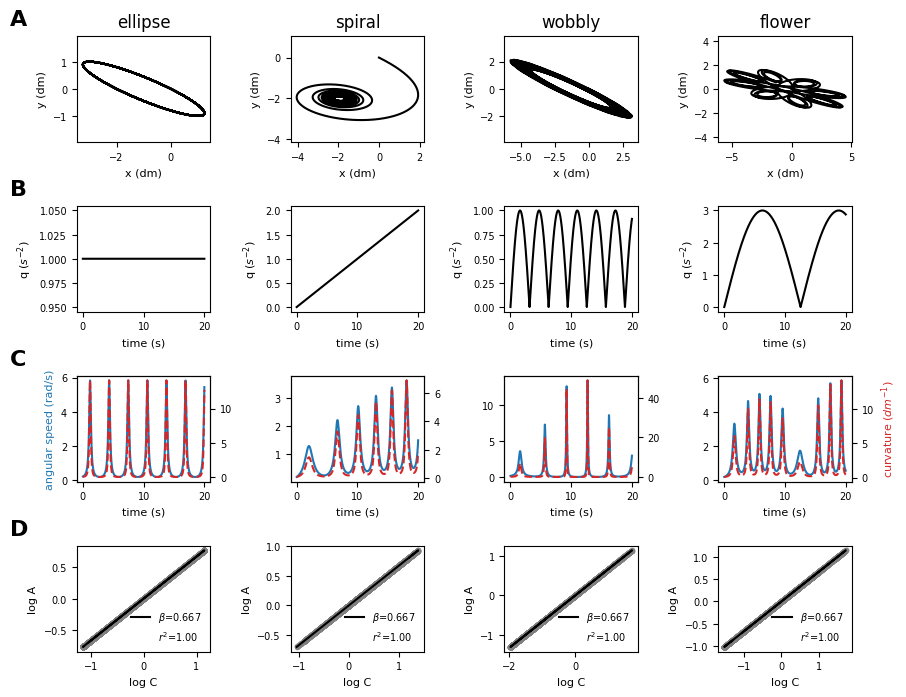

In [0]:
# Figure 1

style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 7
matplotlib.rcParams['ytick.labelsize'] = 7
matplotlib.rcParams['axes.labelsize'] = 8
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(4, 4, figsize=[10, 8])
axf = ax.flat
subplots_adjust(hspace=0.6, wspace=0.6)

  
for i, s in enumerate("ABCD"):
  axf[i * 4].text(-0.5, 1.1, s, size=16, weight="bold", transform = axf[i*4].transAxes)

  
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  figure_plot( axf[i], c.x[::20], c.y[::20], curve)

  take = 20000
  axf[4 + i].plot(c.t[:take], c.q[:take], color="k")
  axf[4 + i].set_xlabel("time (s)")
  axf[4 + i].set_ylabel(r"q ($s^{-2}$)")
  
  
  c1 = "tab:blue"; c2 = "tab:red"
  ax1 = axf[8 + i]
  ax1.set_xlabel("time (s)")
  if i == 0:  ax1.set_ylabel("angular speed (rad/s)", color=c1)
  ax1.plot(c.t[:take:20], abs(c.A[:take:20]), "-", color=c1)
  ax2 = ax1.twinx()
  ax2.plot(c.t[:take:20], c.C[:take:20], "--", color= c2)
  if i == 3: ax2.set_ylabel(r"curvature ($dm^{-1}$)", color=c2)
  
  a = axf[12+i]
  a.plot(c.logC[::20], c.logA[::20], '.', color="gray")
  beta, offset, r, p_v, std_err = stats.linregress(c.logC, c.logA)
  r2 = r*r
  reg_line1 = [beta * i + offset for i in c.logC[::20]]
  a.plot(c.logC[::20], reg_line1, '-', color="black", label=r"$\beta$={:.3f}".format(beta))
  a.plot([],[], color=(0,0,0,0), label="$r^2$={:.2f}".format(r2))
  a.legend(loc="lower right", prop={"size":7}, frameon=False)
  a.set_xlabel("log C")
  a.set_ylabel("log A")    

fn = "Figure1.pdf"
savefig(fn)
print(os.path.getsize(fn) / (1024* 1024))
files.download(fn)
show ()
  

filesize 1.0225162506103516


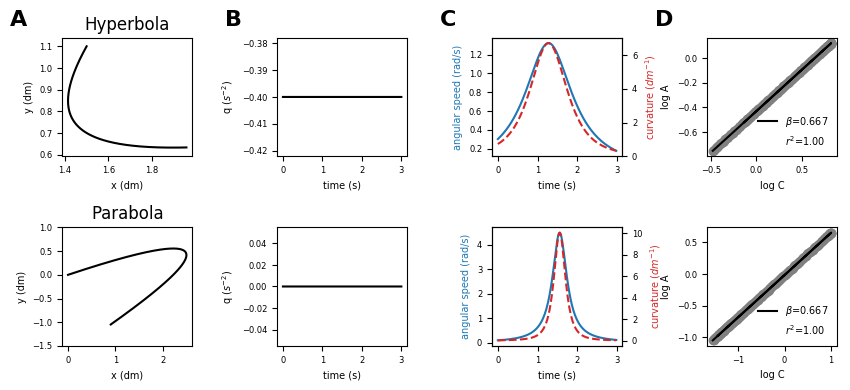

In [0]:
#Supplementary Figure 1
# Hyperbola 
dt = 0.001
t = arange(0, 3, dt)

A0, A1, A2 = 1, 1, 0.5
B0, B1, B2 = 1, 1, 0.1
w = -0.4
hx = A1 * exp(w * t)  + A2 * exp(-w * t)
hy = B1 * exp(w * t)  + B2 * exp(-w * t)
hr = analyze(hx, hy, t)
hr.q = repeat(w, len(hr.t))

# Parabola
A0, A1, A2 = 0, 3, -0.9
B0, B1, B2 = 0, 1, -0.45
px = A0 * t  + A1 * t + A2 * t**2
py = B0 * t  + B1 * t + B2 * t**2
pr = analyze(px, py, t)
pr.q = repeat(0, len(pr.t))

style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42


fig, ax = subplots(2, 4, figsize=[10, 4])
subplots_adjust(hspace=0.6, wspace=0.65)
#subplots_adjust(hspace=0.5, wspace=0.4)


for i, s in enumerate("ABCD"):
  ax[0, i].text(-0.4, 1.1, s, size=16, weight="bold", transform = ax[0, i].transAxes)


for i, x, y, r, plot_title in [(0, hx, hy, hr, "Hyperbola"), [1, px, py, pr, "Parabola"]]:
  figure_plot(ax[i, 0], x, y, plot_title, "black")

  take = 10000
  ax[i, 1].plot(r.t[:take], r.q[:take], color="k")
  ax[i, 1].set_xlabel("time (s)")
  ax[i, 1].set_ylabel(r"q ($s^{-2}$)")
  
  c1 = "tab:blue"; c2 = "tab:red"
  ax[i, 2].set_xlabel("time (s)")
  ax[i, 2].set_ylabel("angular speed (rad/s)", color=c1)
  ax[i, 2].plot(r.t[:take:20], abs(r.A[:take:20]), "-", color=c1)
  ax2 = ax[i, 2].twinx()
  ax2.plot(r.t[:take:20], r.C[:take:20], "--", color= c2)
  ax2.set_ylabel(r"curvature ($dm^{-1}$)", color=c2)
  
  
  reg_line1 = [r.beta * i + r.offset for i in r.logC[::20]]
  ax[i, 3].plot(r.logC[::20], r.logA[::20], "o", color="gray")
  ax[i, 3].plot(r.logC[::20], reg_line1, '-', color="black", label=r"$\beta$={:.3f}".format(r.beta))
  ax[i, 3].plot([],[], color=(0,0,0,0), label="$r^2$={:.2f}".format(r.r2))
  ax[i, 3].legend(loc="lower right", prop={"size":7}, frameon=False)
  ax[i, 3].set_xlabel("log C")
  ax[i, 3].set_ylabel("log A")

fn = "Supplementary Figure 1.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
files.download(fn)
show ()

filesize 1.065159797668457


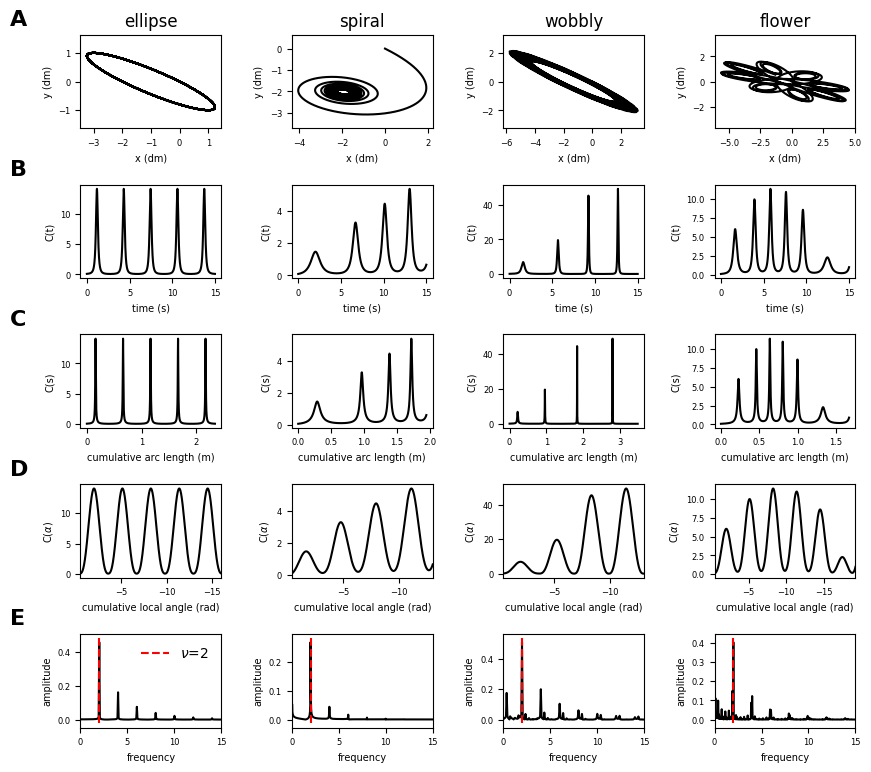

In [0]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(5, 4, figsize=[10, 9])
subplots_adjust(hspace=0.6, wspace=0.5)

for i, s in enumerate("ABCDE"):
  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)

  
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  figure_plot(ax[0,i], c.x[::20], c.y[::20], curve)
  
  tk = 15000
  a = ax[1, i]
  a.plot(c.t[:tk], c.C[:tk], color="black")
  a.set_ylabel("C(t)")
  a.set_xlabel("time (s)")
  
  a = ax[2, i]
  a.plot(0.1 * c.s[:tk:20], c.C[:tk:20], color="k")
  a.set_ylabel("C(s)")
  a.set_xlabel("cumulative arc length (m)")

  
  a = ax[3, i]
  a.plot(c.angle[:tk], c.C[:tk], color="k")
  a.set_xlim(c.angle[0], c.angle[tk])
  a.set_ylabel(r"C($\alpha$)")
  a.set_xlabel("cumulative local angle (rad)")
  
  
  a=ax[4,i]
  a.plot(c.spectrum_F, c.spectrum_Y, color="k")
  a.set_xlim(0, 15)
  a.set_xlabel("frequency")
  a.set_ylabel("amplitude")
  yl = a.get_ylim()
  a.plot([2,2], yl, "--",color="red", label=r"$\nu$=2")  
  #a.legend(frameon=False)

ax[4,0].legend(frameon=False)

fn = "Figure2.pdf"
savefig(fn, format="pdf")
print("filesize", os.path.getsize(fn) / (1024* 1024))
files.download(fn)
show ()


In [0]:
def pow_spec_nolog(x, y, t, dt = 0.001, dtheta=0.001, cutoff = None):
  xs, ys, ts = rss(x, y, t, dt, cutoff)
  xsf = interpolate.UnivariateSpline(ts, xs, k=3, s=0)
  ysf = interpolate.UnivariateSpline(ts, ys, k=3, s=0)
  dx = xsf.derivative(1)(ts)
  dy = ysf.derivative(1)(ts)
  ddx = xsf.derivative(2)(ts)
  ddy = ysf.derivative(2)(ts)
  angle = unwrap(arctan2(dy, dx))
  vel = sqrt(dx**2.0 + dy**2.0)
  D0 = abs(ddy * dx - ddx * dy)
  D = [NaN if d == 0.0 else d for d in D0]
  R = (vel**3.0) / D
  C = 1.0 / R
  anglef = interpolate.UnivariateSpline(ts, angle, k=3, s=0)
  angledf = anglef.derivative(1)
  abs_angle_d = abs(angledf(ts))
  abs_angle_df = interpolate.UnivariateSpline(ts, abs_angle_d, k=3, s=0)
  abs_angle = abs_angle_df.antiderivative(1)(ts)
  curvature_fun = interpolate.UnivariateSpline(abs_angle, C, k=3, s=0)
  th = arange(abs_angle[0], abs_angle[-1], dtheta)
  curvature = curvature_fun(th) 
  freq, Y = get_fft(signal.detrend(curvature), (2 * pi) / dtheta)
  return freq, Y


for i, curve in enumerate(curves.columns):
  c = curves[curve]
  c.F_nolog, c.Y_nolog = pow_spec_nolog(c.x, c.y, c.t) 


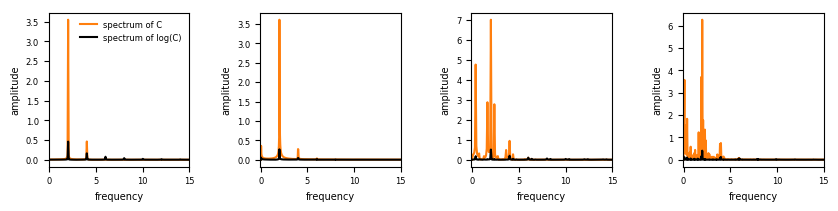

In [0]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(1, 4, figsize=[10, 2])
subplots_adjust(hspace=0.6, wspace=0.5)

#for i, s in enumerate("ABCDE"):
#  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)

  
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  a=ax[i]
  a.plot(c.F_nolog, c.Y_nolog , color="tab:orange", label="spectrum of C")
  a.plot(c.spectrum_F, c.spectrum_Y, color="k", label="spectrum of log(C)")
  a.set_xlim(-0.10, 15)
  a.set_xlabel("frequency")
  a.set_ylabel("amplitude")
  yl = a.get_ylim()
  #a.plot([2,2], yl, "--",color="red", label=r"$\nu$=2")  
  #a.legend(frameon=False)

ax[0].legend(frameon=False, fontsize=6)

fn = "Spectrum_C_vs_LogC.pdf"
savefig(fn, format="pdf")
#print("filesize", os.path.getsize(fn) / (1024* 1024))
show ()

In [0]:
files.download(fn)

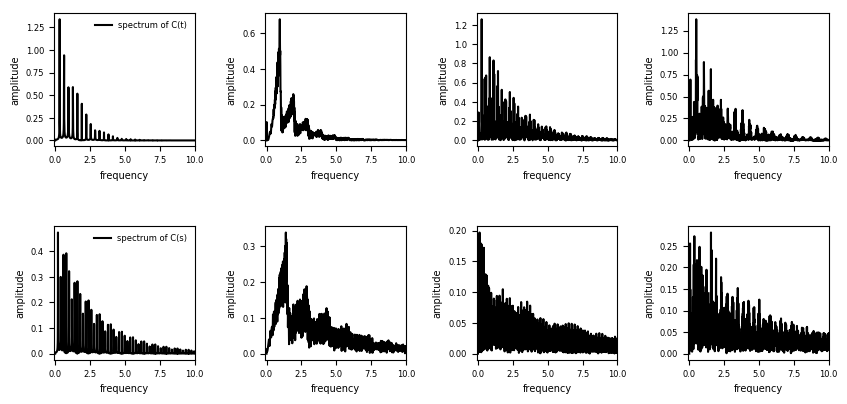

In [0]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(2, 4, figsize=[10, 4.5])
subplots_adjust(hspace=0.6, wspace=0.5)

#for i, s in enumerate("ABCDE"):
#  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  a=ax[0, i]
  freq, Y = get_fft(signal.detrend(c.C), 1.0/dt)
  a.plot(freq, Y, color="k", label="spectrum of C(t)")
  a.set_xlim(-0.10, 10)
  a.set_xlabel("frequency")
  a.set_ylabel("amplitude")
  
  a=ax[1, i]
  
  csf = interpolate.UnivariateSpline(c.s[:-1], c.C, k=3, s=0)
  sdt = np.arange(c.s[0], c.s[-1], 0.001)
  cs = csf(sdt)
  
  freq, Y = get_fft(signal.detrend(cs), 1.0/0.001)
  a.plot(freq, Y, color="k", label="spectrum of C(s)")
  a.set_xlim(-0.10, 10)
  a.set_xlabel("frequency")
  a.set_ylabel("amplitude")


ax[0, 0].legend(frameon=False, fontsize=6)
ax[1, 0].legend(frameon=False, fontsize=6)

fn = "Spectrum_C(t) and C(s).pdf"
savefig(fn, format="pdf")
#print("filesize", os.path.getsize(fn) / (1024* 1024))
show ()

In [0]:
files.download(fn)

--2019-07-24 14:00:37--  https://raw.githubusercontent.com/adam-matic/purity_scaling_optimality/master/February1986MasDer%20tracing%20ellipse%2010.4.2019.%2016.06.34%20.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44244 (43K) [text/plain]
Saving to: ‘February1986MasDer tracing ellipse 10.4.2019. 16.06.34 .txt’

February1986MasDer  100%[===================>]  43.21K  --.-KB/s    in 0.02s   

2019-07-24 14:00:37 (1.69 MB/s) - ‘February1986MasDer tracing ellipse 10.4.2019. 16.06.34 .txt’ saved [44244/44244]



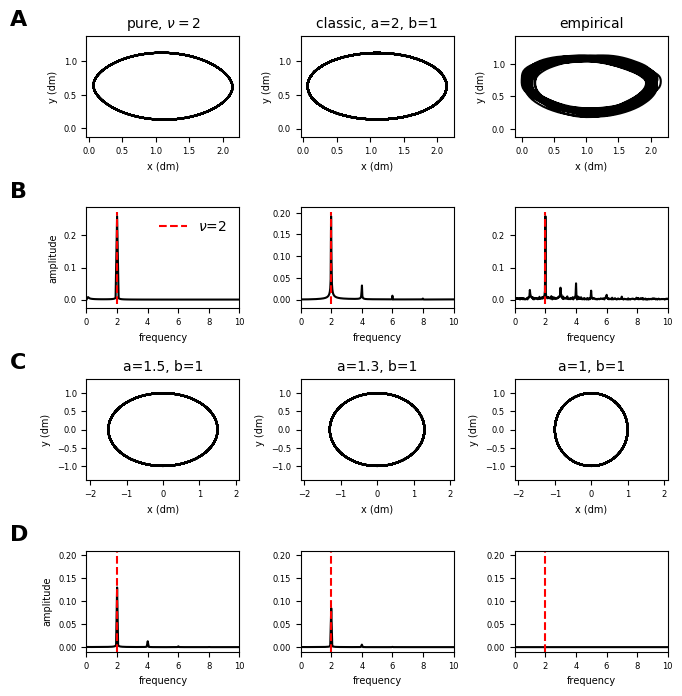

In [0]:
import glob
dt = 0.001

!wget https://raw.githubusercontent.com/adam-matic/purity_scaling_optimality/master/February1986MasDer%20tracing%20ellipse%2010.4.2019.%2016.06.34%20.txt

fs = glob.glob("*tracing ellipse 10*.txt")
f = fs[0]
d = pd.read_csv(f, sep = " ", names = ["t", "x", "y"])
d.t /= 1000

ptomm = 2.16/1920 # px to dm factor for Samsung T580

hx, hy, ht = get_pure_trajectory(dt=dt, scale = 500, th0=-0.8, x0=150, y0=400, N=20)

ct = arange(ht[0], ht[-1], dt)
cx = 980 + 920 * cos( 2*pi * ct )
cy = 560 + 440 * sin( 2*pi * ct )

style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42


fs, ax = subplots(4, 3, figsize=(7.5, 8))
subplots_adjust(hspace=0.7, wspace=0.4)

for i, s in enumerate("ABCD"):
  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)


for i, x, y, t, name in [(0, hx, hy, ht, r"pure, $\nu=2$"), (1, cx, cy, ct, "classic, a=2, b=1"), (2, d.x, d.y, d.t, "empirical")]:
  x = x * ptomm
  y = y * ptomm
  figure_plot(ax[0,i], x, y, name)
  ax[0,i].set_title(name, fontsize=10)
  
  F, Y = pow_spec(x, y, t, cutoff=10)
  a = ax[1, i]
  a.plot(F, Y, color="k")
  a.set_xlim(0, 10)
  a.set_xlabel("frequency")
  yl = a.get_ylim()
  a.plot([2,2], yl, "--",color="red", label=r"$\nu$=2")

ax[1, 0].legend(frameon=False)
ax[1, 0].set_ylabel("amplitude")
  


t = arange(0, 15, 0.01)
for i, a in enumerate([1.5, 1.3, 1]):
  x = a * cos( 2*pi * t )
  y = 1 * sin( 2*pi * t )

  ax[2, i].plot(x, y, color="black")
  ax[2, i].axis("equal")
  ax[2, i].set_title(f"a={a}, b=1", fontsize=10)
  
  ax[2, i].set_xlim(-2.1, 2.1)
  ax[2, i].set_ylim(-2.1, 2.1)
  ax[2, i].set_xlabel("x (dm)")
  ax[2, i].set_ylabel("y (dm)")
  
  f, y = pow_spec(x, y, t, cutoff=None)
  ax[3, i].plot(f, y, color="black")
  ax[3, i].set_xlim(0, 10)
  ax[3, i].set_ylim(-0.01, 0.21)
  ax[3, i].set_xlabel("frequency")
  yl = ax[3, i].get_ylim()
  ax[3, i].plot([2,2], yl, "--",color="red", label=r"$\nu$=2")


ax[3,0].set_ylabel("amplitude")  

fn = "Supplementary Figure 2.2.pdf"
#savefig(fn, format="pdf")
#print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()

In [0]:
def plot_vectors(fig, a, curve_data, tk = arange(0, 6300, 100), index = 0,  animate=False, axis_lims=""):
  c = curve_data
  r = analyze(c.x, c.y, c.t)
  x = r.x[tk]
  y = r.y[tk]
  dx = r.xvel[tk]
  dy = r.yvel[tk]
  ddx = r.xacc[tk]
  ddy = r.yacc[tk]
  xj = r.xjerk[tk]
  yj = r.yjerk[tk]
  P = (ddx*dx + ddy*dy)
  m = a.scatter(x=x , y=y, c=P, cmap="seismic") #, vmin=0, vmax=+2)
  CB = fig.colorbar(m, ax=a, orientation='vertical', shrink = 0.8) 
  CB.ax.set_ylabel("P")
  vk = 1

  
  def update(i):
    pxs = [x[i], x[i] + vk* dx[i], x[i] + vk * dx[i] + vk * ddx[i], x[i] + vk* ddx[i]]
    pys = [y[i], y[i] + vk* dy[i], y[i] + vk * dy[i] + vk * ddy[i], y[i] + vk* ddy[i]] 
    D_area = Polygon(xy = asarray(list(zip(pxs, pys))), color="black", closed=True, fill=False, hatch="///", label="D")
    p1 = fap((x[i], y[i]), (x[i] + vk * dx[i],  y[i] + vk * dy[i]),  color="tab:red", mutation_scale=20, label=r"$\vec v$")
    p2 = fap((x[i], y[i]), (x[i] + vk * ddx[i], y[i] + vk * ddy[i]),  color="tab:blue", mutation_scale=20, label=r"$\vec a$")
    p3 = fap((x[i], y[i]), (x[i] + vk * xj[i], y[i] + vk * yj[i]),  color="darkgreen", mutation_scale=20, label=r"$\vec j$")
    return [D_area, p1, p2, p3]

  patches = update(index) 
  for p in patches: a.add_patch(p)
    
  a.set_xlabel("x (dm)")
  a.set_ylabel("y (dm)")
  a.legend(handles = patches, frameon=False, prop={"size":8})
  a.axis("equal")
  a.axis(axis_lims)

  def animate(i, ax):
    a.axis(axis_lims)
    a.patches = []
    patches = update(i) 
    for p in patches: a.add_patch(p)
    return patches

  anim = empty()
  if animate:
    anim = animation.FuncAnimation(fig, animate, arange(len(tk)), interval = 150, fargs=[a])
  
  
  return anim

# Animations

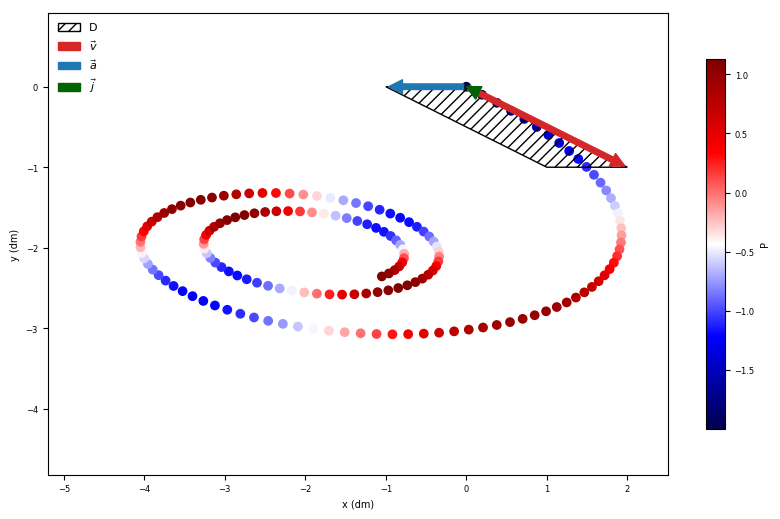

In [0]:
fig, ax = subplots(1,1, figsize=(10, 6))
tk = arange(0, 16300, 100) 
axis_lims = [-5.2, 2.5, -5, 1.1]
anim = plot_vectors(fig, ax, curves.spiral, tk, axis_lims = axis_lims, animate=True)
anim.save('spiral.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
files.download('spiral.mp4') 

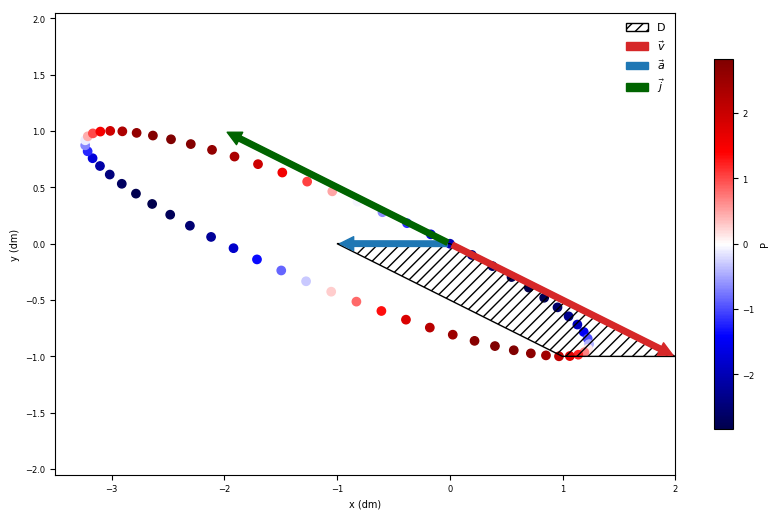

In [0]:
fig, ax = subplots(1,1, figsize=(10, 6))
axis_lims = [-3.5, 2, -1.5, 1.5]
anim = plot_vectors(fig, ax, curves.ellipse, axis_lims = axis_lims, animate=True)
anim.save('ellipse.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
files.download('ellipse.mp4') 

# Constant D, but not mechanical power

filesize 1.0629138946533203


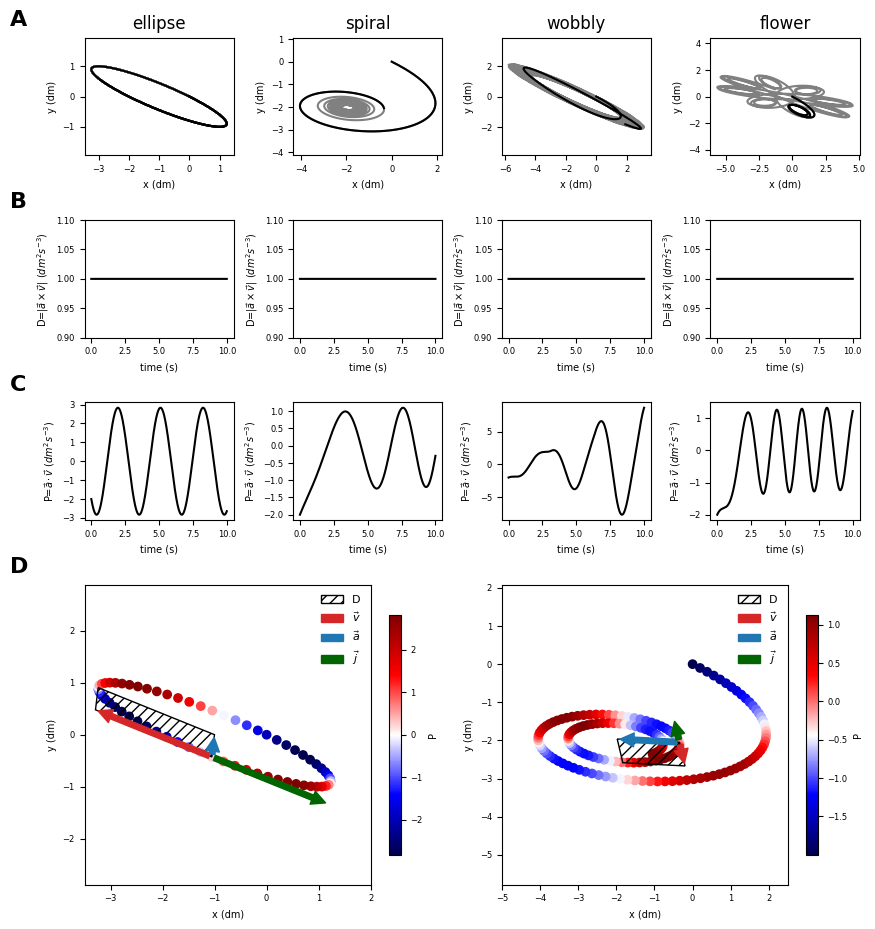

In [0]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(5, 4, figsize=[10, 11])
subplots_adjust(hspace=0.55, wspace=0.4)

for i, s in enumerate("ABC"):
  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  figure_plot(ax[0, i], c.x[::20], c.y[::20], curve, color="gray")
  
  take = arange(0, int(10 / dt))
  ax[0, i].plot(c.x[take], c.y[take], color="black")
  
  a = ax[1, i]
  a.plot(c.t[take], c.D[take], color="k")
  mD = mean(c.D)
  a.set_ylim(1-0.1, 1+0.1)
  a.set_xlabel("time (s)")
  a.set_ylabel(r"D=$|\vec a \times \vec v|\ (dm^2 s^{-3})$ ")
  
  a = ax[2, i]
  a.plot(c.t[take], c.P[take], color="k")
  a.set_ylabel(r"P=$\vec a \cdot \vec{v}\ (dm^2 s^{-3})$")
  a.set_xlabel("time (s)")


gs1 = ax[3, 0].get_gridspec()
gs2 = ax[4, 2].get_gridspec()
for a in ax.flat[-8:]: a.remove()

aa = fig.add_subplot(gs1[3:5, 0:2]) 
bb = fig.add_subplot(gs2[3:5, 2:4])  
aa.text(-0.5, 1.1, "D", size=16, weight="bold", transform = ax[i, 0].transAxes)
plot_vectors(fig, aa, curves.ellipse, index = 27, axis_lims = [-3.5, 2, -1.5, 1.5])
plot_vectors(fig, bb, curves.spiral, tk = arange(0, 16300, 100), index = 100, axis_lims=[-5, 2.5, -5, 1.3])
  
  
fn = "Figure3.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
files.download(fn)
show ()


## Mechanical work is not minimal for BETA=2/3


In [0]:
tot = 6  # total number of seconds
take = arange(0, int(tot / dt))
target_betas = arange(-0.1, 1.2, 0.01) 

for column in curves.columns:
  c = curves[column]
  c.BETAS = [retrack(c.x[take], c.y[take], c.t[take], tb) for tb in target_betas]
  

filesize 0.685272216796875


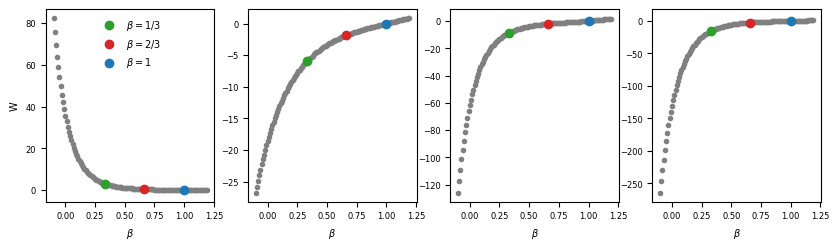

In [15]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42


fig, ax = subplots(1, 4, figsize=(10, 2.5))
#subplots_adjust(hspace=0.5, wspace=0.4)

betas = [0.33, 0.66, 1.0]
labels = ["1/3", "2/3", "1"]
colors = ["tab:green", "tab:red", "tab:blue"]



for i, curve in enumerate(curves.columns):
  a = ax[i]
  c = curves[curve]
  wms = [sum(c.P) * dt for c in c.BETAS]
  a.plot(target_betas, wms, '.', color="gray")
  
  for j in range(3):
    idx = where(abs(target_betas - betas[j]) < 0.005)[0][0] 
    a.scatter(betas[j], wms[idx], color = colors[j], label=fr"$\beta={labels[j]}$", zorder=10)
  
  if i == 0: 
    a.legend(loc="upper center", prop={"size":7}, frameon=False)
    a.set_ylabel("W")
  
  #a.plot([tot, tot], a.get_ylim(), color="black", lw=2)
  a.set_xlabel(r"$\beta$")
  

fn = "FigureNotMinimalWork.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()
  

In [0]:
files.download(fn)


# Calculating integral of D for a range of betas

In [0]:
tot = 6  # total number of seconds
take = arange(0, int(tot / dt))

for column in curves.columns:
  c = curves[column]
  target_betas = arange(0.1, 1.1, 0.01) 
  c.BETAS = [retrack(c.x[take], c.y[take], c.t[take], tb) for tb in target_betas]


filesize 1.0579395294189453


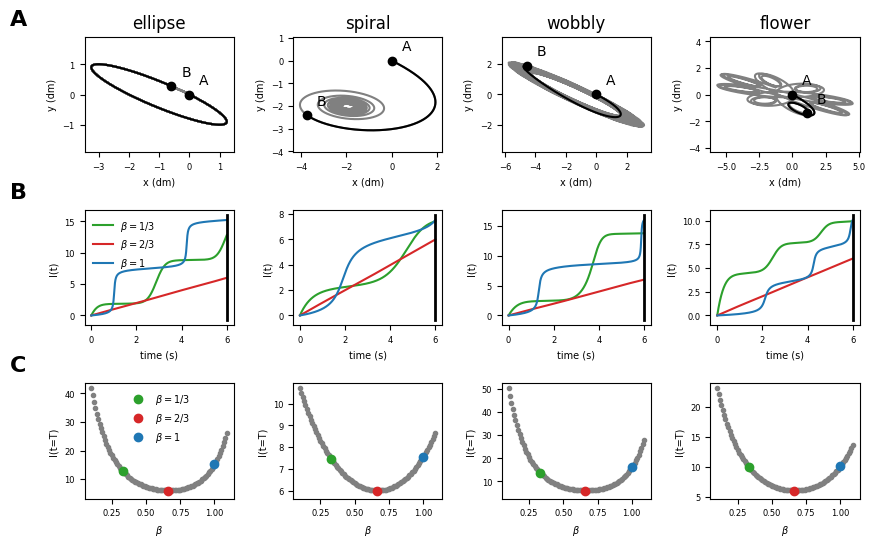

In [17]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
rcParams['pdf.fonttype'] = 42


fig, ax = subplots(3, 4, figsize=(10, 6))
subplots_adjust(hspace=0.5, wspace=0.4)

betas = [0.33, 0.66, 1.0]
labels = ["1/3", "2/3", "1"]
colors = ["tab:green", "tab:red", "tab:blue"]
    
take = arange(0, int(tot / dt))
for i, s in enumerate("ABC"):
  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)
  
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  a = ax[0, i]
  figure_plot(a, c.x, c.y, curve, "gray")
  a.plot(c.x[take], c.y[take], color="black", zorder=9)
  
  A = (c.x[take][0], c.y[take][0])
  B = (c.x[take][-1], c.y[take][-1])
  a.scatter(*A, marker='o', color="black", zorder=10)
  a.scatter(*B, marker='o', color="black", zorder=10)
  
  a.annotate("A", A, xytext=(+10, +10), textcoords='offset pixels', color="black")
  a.annotate("B", B, xytext=(+10, +10), textcoords='offset pixels', color="black")
  
  
  b = ax[2, i]  
  integralDT = [sum(d.D) * dt for d in c.BETAS]
  b.plot(target_betas,  integralDT, ".", color="gray", zorder=0)
  b.set_xlabel(r"$\beta$")  
  b.set_ylabel("I(t=T)")
  
  a = ax[1, i]
  for j in range(3):
    idx = where(abs(target_betas - betas[j]) < 0.001)[0][0]  
    cc = c.BETAS[idx]
    I = cumsum(cc.D) * dt
    a.plot(cc.t, I, color=colors[j], label = fr"$\beta={labels[j]}$")
    b.scatter(betas[j], sum(cc.D) * dt, color = colors[j], label=fr"$\beta={labels[j]}$")
  
  if i == 0: 
    a.legend(loc="upper left", prop={"size":7}, frameon=False)
    b.legend(loc="upper center", prop={"size":7}, frameon=False)
  
  a.plot([tot, tot], a.get_ylim(), color="black", lw=2)
  a.set_ylabel("I(t)")
  a.set_xlabel("time (s)")
  

fn = "Figure 4.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()



**Integral (D)**

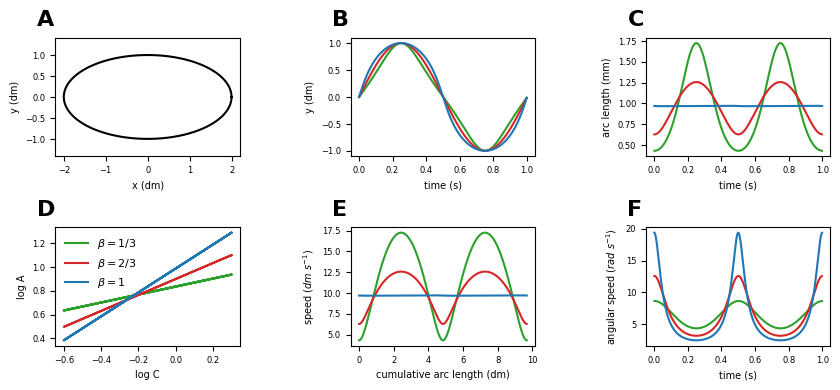

In [6]:

# Supplementary 4.1

t = arange(0, 1, 0.001)
x = 2 * cos(t * 2 * pi)
y = 1 * sin(t * 2 * pi)

style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams["axes.prop_cycle"] = cycler(color=['tab:green', 'tab:red', 'tab:blue', 'black'])
rcParams['pdf.fonttype'] = 42


fig, axs = subplots(2, 3, figsize=(10, 4))
ax = axs.flat

subplots_adjust(hspace=0.6, wspace=0.6)

for i, s in enumerate("ABCDEF"):
  ax[i].text(-0.1, 1.1, s, size=16, weight="bold", transform = ax[i].transAxes)

  
figure_plot(ax[0], x, y)

r13 = retrack(x, y, t, target_beta = 1/3)
r23 = retrack(x, y, t, target_beta = 2/3)
r1 = retrack(x, y, t, target_beta = 1)

ax[1].plot(r13.t, r13.y, label=r"y, $\beta=1/3$" )
ax[1].plot(r23.t, r23.y, label=r"y, $\beta=2/3$")
ax[1].plot(r1.t, r1.y, label=r"y, $\beta=1$")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("y (dm)")
#ax[1].legend(prop={"size":8}, frameon=False)

ax[2].plot(r13.t, r13.ds * 100, label=r"ds, $\beta=1/3$")
ax[2].plot(r23.t, r23.ds * 100, label=r"ds, $\beta=2/3$")
ax[2].plot(r1.t, r1.ds * 100, label=r"ds, $\beta=1$")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("arc length (mm)")
#ax[2].legend(prop={"size":8}, frameon=False)

ax[3].plot(r13.logC, r13.logA, label=r"$\beta=1/3$")
ax[3].plot(r23.logC, r23.logA, label=r"$\beta=2/3$")
ax[3].plot(r1.logC, r1.logA, label=r"$\beta=1$")
ax[3].set_xlabel("log C")
ax[3].set_ylabel("log A")
ax[3].legend(prop={"size":8}, frameon=False)


ax[4].plot(cumsum(r13.ds), r13.V, label=r"v, $\beta=1/3$")
ax[4].plot(cumsum(r23.ds), r23.V, label=r"v, $\beta=2/3$")
ax[4].plot(cumsum(r1.ds), r1.V, label=r"v, $\beta=1$")
ax[4].set_xlabel("cumulative arc length (dm)")
ax[4].set_ylabel(r"speed ($dm\ s^{-1}$)")
#ax[4].legend(prop={"size":8}, frameon=False)

ax[5].plot(r13.t, r13.A, label=r"A, $\beta=1/3$")
ax[5].plot(r23.t, r23.A, label=r"A, $\beta=2/3$")
ax[5].plot(r1.t, r1.A, label=r"A, $\beta=1$")
ax[5].set_xlabel("time (s)")
ax[5].set_ylabel(r"angular speed ($rad\ s^{-1}$)")
#ax[5].legend(prop={"size":8}, frameon=False)


fn = "Supplementary Figure 4.1.pdf"
#savefig(fn, format="pdf", backgroud=False)
#print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()

-7.499998691132995e-07 0.8221076400952121
filesize 0.6841793060302734


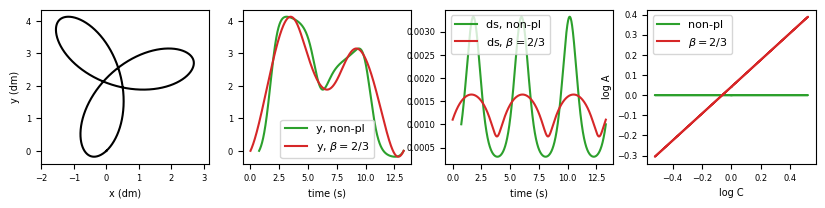

In [7]:

# Supplementary 4.3

#x,y,t = get_pure_trajectory(x0=0, y0=0, eps=1.2, v=2, th0=1, N=2, scale=1, beta=2.0 / 3.0, k=2, dtheta = 0.001, dt = 0.001)

eps = 1.2
dtheta = 0.001
th0 = 0.75
N = 4
v = 3/2
theta = arange(th0, pi * N + th0, dtheta)
thsub = theta - th0
x = cumsum(dtheta * cos(theta) * exp(eps * sin(v * thsub)))
y = cumsum(dtheta * sin(theta) * exp(eps * sin(v * thsub)))
t = theta

r = analyze(x,y,t)
print(r.beta, r.r2)

#style.use("default")
fig, ax = subplots(1, 4, figsize=(10, 2))

figure_plot(ax[0], x, y, color="black")
r23 = retrack(x, y, t, target_beta = 2/3)

ax[1].plot(t, y, label=r"y, non-pl")
ax[1].plot(r23.t, r23.y, label=r"y, $\beta=2/3$")
ax[1].set_xlabel("time (s)")
ax[1].legend(prop={"size":8})

ax[2].plot(r.t, r.ds, label=r"ds, non-pl")
ax[2].plot(r23.t, r23.ds, label=r"ds, $\beta=2/3$")
ax[2].set_xlabel("time (s)")
ax[2].legend(prop={"size":8})

ax[3].plot(r.logC, r.logA, label=r"non-pl")
ax[3].plot(r23.logC, r23.logA, label=r"$\beta=2/3$")
ax[3].set_xlabel("log C")
ax[3].set_ylabel("log A")
ax[3].legend(prop={"size":8})

fn = "Supplementary Figure 4.3.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()

# Integral of affine velocity

filesize 1.0478944778442383


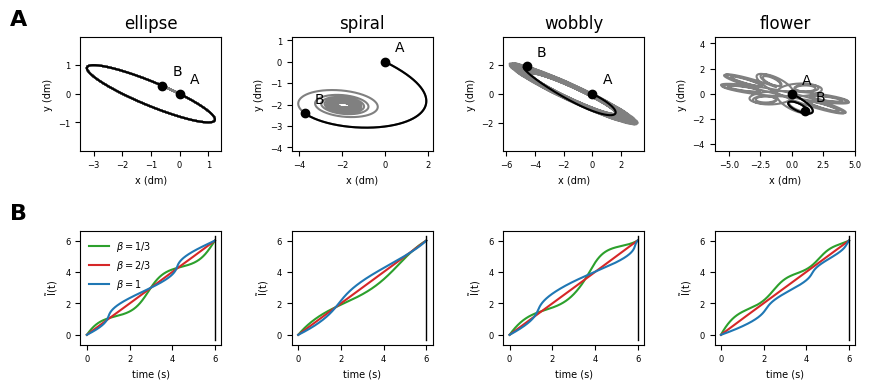

In [8]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams["axes.prop_cycle"] = cycler(color=['tab:green', 'tab:red', 'tab:blue', 'black'])
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(2, 4, figsize=(10, 4))
subplots_adjust(hspace=0.7, wspace=0.5)

betas = [0.33, 0.66, 1.0]
labels = ["1/3", "2/3", "1"]
colors = ["tab:green", "tab:red", "tab:blue"]

take = arange(0, int(tot / dt))

for i, s in enumerate("AB"): ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)
  

for i, curve in enumerate(curves.columns):
  c = curves[curve]
  figure_plot(ax[0, i], c.x, c.y, curve, "gray")
  ax[0, i].plot(c.x[take], c.y[take], color="black")
  a = ax[0, i]
  A = (c.x[take][0], c.y[take][0])
  B = (c.x[take][-1], c.y[take][-1])
  a.scatter(*A, marker='o', color="black", zorder=10)
  a.scatter(*B, marker='o', color="black", zorder=10)
  
  a.annotate("A", A, xytext=(+10, +10), textcoords='offset pixels', color="black")
  a.annotate("B", B, xytext=(+10, +10), textcoords='offset pixels', color="black")
  
  
  
  a = ax[1, i]
  for j in range(3):
    idx = where(abs(target_betas - betas[j]) < 0.001)[0][0]  
    cc = c.BETAS[idx]
    I = cumsum(cc.D ** (1/3)) * dt
    a.plot(cc.t, I, color=colors[j], label = fr"$\beta={labels[j]}$")
  
  if i == 0: 
    a.legend(loc="upper left", prop={"size":7}, frameon=False)
  
  a.set_ylabel(r"$\regular{\tildeI(t)}$")
  a.set_xlabel("time (s)")
  a.plot([tot, tot], a.get_ylim(), color="black", lw=1)

fn = "Figure 5.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()


filesize 1.0514535903930664


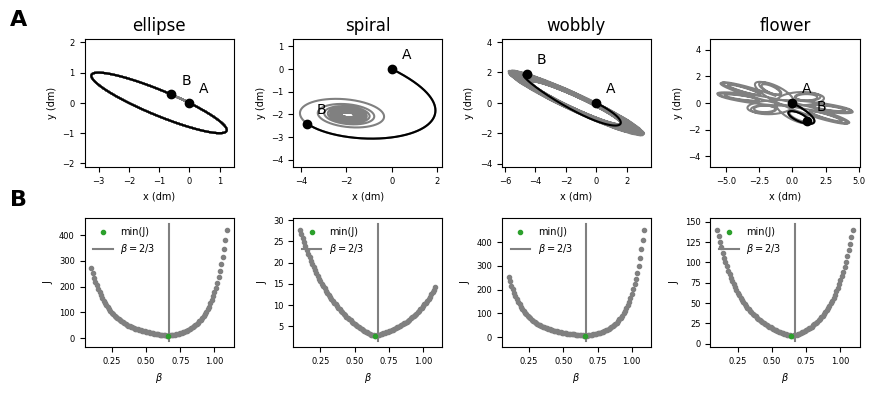

In [10]:
#style.use("default")
fig, ax = subplots(2, 4, figsize=(10, 4))
subplots_adjust(hspace=0.4, wspace=0.4)
rcParams['pdf.fonttype'] = 42

betas = [0.33, 0.66, 1.0]
labels = ["1/3", "2/3", "1"]
colors = ["tab:green", "tab:red", "tab:blue"]

for i, s in enumerate("AB"):
  ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)
  
for i, curve in enumerate(curves.columns):
  c = curves[curve]
  figure_plot(ax[0, i], c.x, c.y, curve, "gray")
  ax[0, i].plot(c.x[take], c.y[take], color="black")
  a = ax[0, i]
  A = (c.x[take][0], c.y[take][0])
  B = (c.x[take][-1], c.y[take][-1])
  a.scatter(*A, marker='o', color="black", zorder=10)
  a.scatter(*B, marker='o', color="black", zorder=10)
  
  a.annotate("A", A, xytext=(+10, +10), textcoords='offset pixels', color="black")
  a.annotate("B", B, xytext=(+10, +10), textcoords='offset pixels', color="black")
  
  a = ax[1, i]  
  Js = [d.J for d in c.BETAS]
  a.plot(target_betas,  Js, ".", color="gray", zorder=0)
  a.set_xlabel(r"$\beta$")  
  a.set_ylabel("J")
  
  mji = argmin(Js)
  
  a.plot([target_betas[mji]], [Js[mji]], '.', label ="min(J)", zorder=5)
  a.plot([2/3, 2/3], a.get_ylim(), "-",  color="gray", label=r"$\beta = 2/3$")
  a.legend(frameon=False, loc="upper left", prop={"size":7})
  

fn = "Figure 6.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()

## Supplementary 5.1

filesize 0.7606983184814453


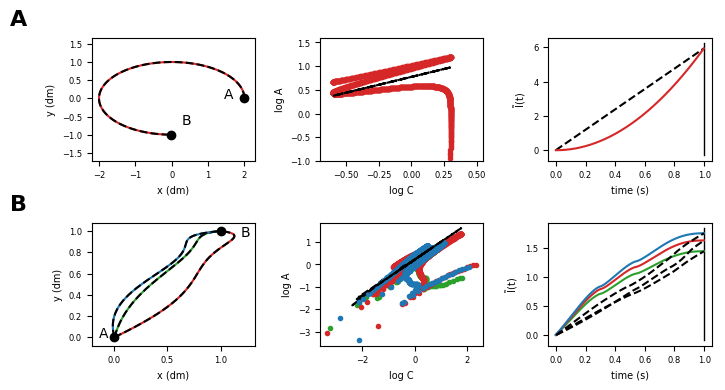

In [0]:
#style.use("default")
fig, ax = subplots(2, 3, figsize=(8, 4))
subplots_adjust(hspace=0.5, wspace=0.4)

for i, s in enumerate("AB"): ax[i, 0].text(-0.5, 1.1, s, size=16, weight="bold", transform = ax[i, 0].transAxes)

t = arange(0, 1, 0.001)
th = t * 1.5 * pi
x = 2 * cos(th)
y = 1 * sin(th)


t2 = t**2
th2 = 1.5 * pi * t2 / t2[-1]  
x2 = 2 * cos(th2)
y2 = 1 * sin(th2)

a = ax[0,0]

step = 10
a.plot(x2[::step], y2[::step], "-", color="tab:red")
a.plot(x [::step], y[::step], "--", color="black")
a.axis("equal"); a.set_xlabel("x (dm)"); a.set_ylabel("y (dm)")

A = (x[0], y[0])
B = (x[-1], y[-1])
a.scatter(*A, marker='o', color="black", zorder=10)
a.scatter(*B, marker='o', color="black", zorder=10)

a.annotate("A", A, xytext=(-20, 0), textcoords='offset pixels', color="black")
a.annotate("B", B, xytext=(+10, +10), textcoords='offset pixels', color="black")


r1 = analyze(x, y, t)
r2 = analyze(x2, y2, t)

a = ax[0, 1]
a.plot(r1.logC, r1.logA, "--", color="black")
a.plot(r2.logC, r2.logA, ".", color="tab:red", zorder=0)
a.set_xlim(-0.7, 0.55)
a.set_ylim(-1, 1.6)
a.set_xlabel("log C"); a.set_ylabel("log A")

ax[0,2].set_ylabel(r"$\regular{\tildeI(t)}$")
ax[0,2].plot(r1.t, cumsum(r1.D**(1/3))*dt, "--", color="black")
ax[0,2].plot(r2.t, cumsum(r2.D**(1/3))*dt, "-", color="tab:red")
ax[0,2].set_xlabel("time (s)")


dt = 0.001
t = arange(0, 1, dt)

Ax, Ay = [0, 0] # x[0], y[0]
Bx, By = [1, 1] # x[-1], y[-1]

xss = []
yss = []
tss = []
for i in range(0, 3):
  random.seed(i)
  xs0 = random.rand(len(t)) + sin(12 * t)
  ys0 = random.rand(len(t)) 
  xs, ys = butter_filter(xs0, ys0, 0.5, 1000)
  xs = xs - xs[0]
  ys = ys - ys[0]
  xs = xs / xs[-1] 
  ys =  ys / ys[-1]   
  
  xss.append(xs)
  yss.append(ys)
  tss.append(t)
  
  d = retrack(xs, ys, t, target_beta = 0.8, target_time = 1)
  xss.append(d.x)
  yss.append(d.y)
  tss.append(d.t)
  
  a = ax[1, 0]
  a.plot(xs, ys)
  a.plot(d.x, d.y, '--', color="black")
  a.axis("equal"); a.set_xlabel("x (dm)"); a.set_ylabel("y (dm)")

A = (xs[0], ys[0])
B = (xs[-1], ys[-1])
a.scatter(*A, marker='o', color="black", zorder=10)
a.scatter(*B, marker='o', color="black", zorder=10)

a.annotate("A", A, xytext=(-15, 0), textcoords='offset pixels', color="black")
a.annotate("B", B, xytext=(+20, -5), textcoords='offset pixels', color="black")

 
  
for i in range(len(xss)):
  r = analyze(xss[i], yss[i], tss[i])
  d13 = cumsum(r.D**(1/3) *dt) 
  if i%2 == 1:
    ax[1, 2].plot(r.t, d13, "--", c="k")
    
    ax[1, 1].plot(r.logC, r.logA, "--", c="k")
    
  else:
    ax[1, 2].plot(r.t, d13)
    ax[1, 1].plot(r.logC, r.logA, ".")

ax[1,1].set_xlabel("log C")
ax[1,1].set_ylabel("log A")
ax[1,2].set_xlabel("time (s)")
ax[1,2].set_ylabel(r"$\regular{\tildeI(t)}$")
  
ax[0, 2].plot([1, 1], ax[0,2].get_ylim(), color="black", lw=1, zorder=0)
ax[1, 2].plot([1, 1], ax[1,2].get_ylim(), color="black", lw=1, zorder=0)


fn = "Supplementary Figure 5.1.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
files.download(fn)
show ()

In [0]:
import glob

!wget https://raw.githubusercontent.com/adam-matic/purity_scaling_optimality/master/homer%20trace%202019-05-17%2014-29-18.txt

f ="homer trace 2019-05-17 14-29-18.txt"
tr, xr, yr = loadtxt(f, skiprows=230, unpack=True)

pxtomm = 0.233 # for Wacom 27QHD
pxtodm = pxtomm / 100

dt=0.005
x, y, t = rss(xr, yr, tr, dt, cutoff = 8)
take = arange(0, len(t) - int(1.5/dt))
x, y, t = x[take] * pxtodm, y[take] * pxtodm, t[take]
t = t - t[0]

r = analyze(x, y, t)
r23 = retrack(r.x, r.y, r.t, target_beta = 2/3, target_time = None )
F, Y = pow_spec(copy(x), copy(y), copy(t), cutoff=None)



filesize 1.7407798767089844


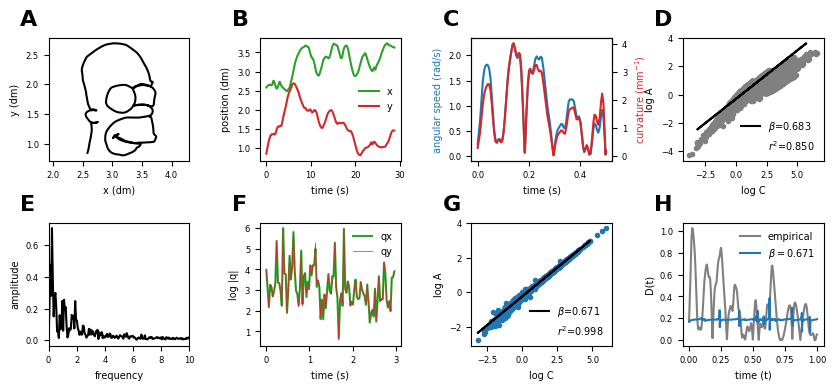

In [0]:
style.use("default")
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams["axes.prop_cycle"] = cycler(color=['tab:green', 'tab:red', 'tab:blue', 'black'])
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(2, 4, figsize=(10, 4))
subplots_adjust(hspace=0.5, wspace=0.5)

axf = ax.flat
for i, s in enumerate("ABCDEFGH"): axf[i].text(-0.2, 1.1, s, size=16, weight="bold", transform = axf[i].transAxes)

a = axf[0]
a.plot(r.x, r.y, color="black")
a.set_xlabel("x (dm)")
a.set_ylabel("y (dm)")
a.axis("equal")

a = axf[1]
a.plot(r.t, r.x, label="x")
a.plot(r.t, r.y, label="y")
a.legend(frameon=False, prop={"size":7})
a.set_xlabel("time (s)")
a.set_ylabel("position (dm)")

tk = arange(0, 500)
c1 = "tab:blue"
c2 = "tab:red"
a = axf[2]
a.set_xlabel("time (s)")
a.set_ylabel("angular speed (rad/s)", color=c1)
a.plot(r.t[tk], r.A[tk], color=c1)
#ax[0, 2].set_ylim(0, 10)
ax2 = a.twinx()
ax2.plot(r.t[tk], r.C[tk], color= c2)
ax2.set_ylabel(r"curvature (mm$^{-1}$)", color=c2)
#ax2.set_ylim(-0, 0.1)

a = axf[3]
a.plot(r.logC, r.logA, '.', color="gray")
a.plot(r.logC[::10], r.offset + r.beta * r.logC[::10], color="black", label=fr"$\beta$={r.beta:.3f}")
a.plot([], [], label=fr"$r^2$={r.r2:.3f}", color=(0,0,0,0))
a.legend( frameon=False, prop={"size":7})
a.set_xlabel("log C")
a.set_ylabel("log A")

a = axf[6]
a.plot(r23.logC, r23.logA, '.', color="tab:blue")
a.plot(r23.logC[::10], r23.offset + r23.beta * r23.logC[::10],  label=fr"$\beta$={r23.beta:.3f}", color="black")
a.plot([], [], label=fr"$r^2$={r23.r2:.3f}", color=(0,0,0,0))
a.legend(frameon=False, prop={"size":7})
a.set_xlabel("log C")
a.set_ylabel("log A")

a = axf[5]
tk = arange(0, 3000, 30)
qtx = r23.xjerk / r23.xvel
a.plot(r23.t[tk], log10(abs(qtx[tk])), label="qx")
qty = r23.yjerk / r23.yvel
a.plot(r23.t[tk], log10(abs(qty[tk])), '-', label="qy", lw=0.5)
a.set_ylabel("log |q|")
a.set_xlabel("time (s)")
a.legend(frameon=False, prop={"size":7})

a = axf[4]
a.plot(F,Y, color="black")
a.set_xlim(0,10)
a.set_xlabel("frequency")
a.set_ylabel("amplitude")

tk = arange(0, 1000)
ax[1, 3].plot(r.t[tk], r.D[tk], label="empirical", color="gray")
ax[1, 3].plot(r23.t[tk], r23.D[tk], label=fr"$\beta = {r23.beta:.3f}$", color="tab:blue")
ax[1, 3].legend(frameon=False, prop={"size":7})
ax[1, 3].set_ylabel("D(t)")
ax[1, 3].set_xlabel("time (t)")



fn = "Figure 7.pdf"
savefig(fn, format="pdf", backgroud=False)
print("filesize", os.path.getsize(fn) / (1024* 1024))
#files.download(fn)
show ()

In [0]:
#!wget https://raw.githubusercontent.com/adam-matic/min_jerk/master/min_jerk.py
import min_jerk

--2019-08-28 13:36:02--  https://raw.githubusercontent.com/adam-matic/min_jerk/master/min_jerk.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6238 (6.1K) [text/plain]
Saving to: ‘min_jerk.py.1’

min_jerk.py.1       100%[===================>]   6.09K  --.-KB/s    in 0s      

2019-08-28 13:36:02 (85.9 MB/s) - ‘min_jerk.py.1’ saved [6238/6238]



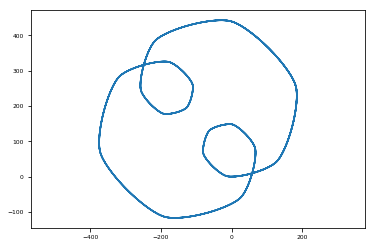

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import math


def multi_curve(x0=0, y0=0, vs=[(2, 1)], t0=0, n=10, scale=100, dt=0.001):
  x, y, t = x0, y0, 0
  xs = []
  ys = []
  while (t < math.pi * n):
    dxs = sum([eps * math.sin(v * (t - t0)) for v, eps in vs])
    dys = sum([eps * math.sin(v * (t - t0)) for v, eps in vs])

    x = x + dt * scale * math.cos(t) * math.exp(dxs)
    y = y + dt * scale * math.sin(t) * math.exp(dys)
    t = t + dt
    xs.append(x)
    ys.append(y)
  return xs, ys

  
x, y = multi_curve(vs=[(2/3, 0.7), (6, 1.0)], dt=0.001, n = 25)
  
%matplotlib inline 
plt.plot(x, y)
plt.axis("equal")
plt.show()
  

In [0]:
@njit
def run_model (T, params):
	K, S, D, dt = params  # gain, slowing, delay and dt
	C = np.zeros(T.shape)
	C[0] = T[0]
	dd = int(D / dt)
	for i in range(len(C) - 1):
		delayed = i - dd if i > dd else 0
		p = T[delayed] - C[delayed]
		C[i+1] = C[i] + (K * p - C[i]) * (dt / S)
	return C

@njit
def run_model_leak (T, params):
	G, L, D, dt = params  # gain, leak, delay, dt
	C = np.zeros(T.shape)
	C[0] = T[0]
	dd = int(D / dt)
	for i in range(len(C) - 1):
		delayed = i - dd if i > dd else 0
		p = T[delayed] - C[delayed]
		C[i+1] = C[i] + (G * p - L * C[i]) * dt
	return C


0.10000500456351442 0.9999755634487328
0.7657415367421699 0.7360437649565313 412083.557479183


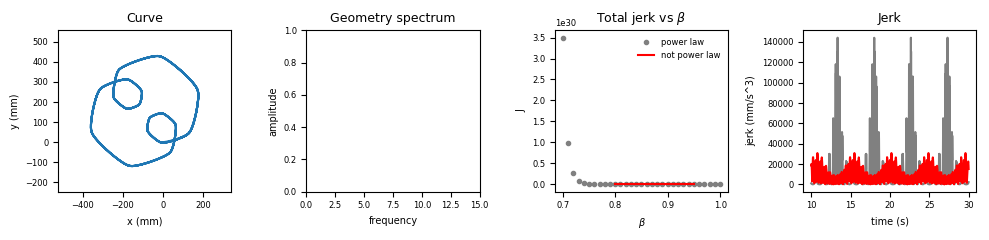

In [0]:
style.use("default")

matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['axes.titlesize'] = 9

#matplotlib.rcParams["axes.prop_cycle"] = cycler(color=['tab:green', 'tab:red', 'tab:blue', 'black'])
rcParams['pdf.fonttype'] = 42

fig, ax = subplots(1, 4, figsize=(10, 2.5))
subplots_adjust(hspace=0.6, wspace=0.5)

dt = 0.001

x, y = multi_curve(vs=[(2/3, 0.7), (6, 1.0)], dt=0.001, n = 25)
t = np.arange(len(x)) * dt
mc = retrack(x, y, t, 0.1)
print(mc.beta, mc.r2)

T = np.array((mc.x, mc.y)).T
cx, cy = run_model_leak(T, [0.66, 0.02, 0.14, dt]).T

ts = mc.t
cut = 3500
m = analyze(cx[cut:-cut], cy[cut:-cut], ts[cut:-cut])
print(m.beta, m.r2, m.J)
m.t = m.t - m.t[0]

ax[0].plot(m.x, m.y)
ax[0].axis("equal")
ax[0].set_xlabel("x (mm)")
ax[0].set_ylabel("y (mm)")
ax[0].set_title("Curve")


f,y = pow_spec(m.x, m.y, m.t)
ax[1].plot(f, y)
ax[1].set_xlim(0, 15)
ax[1].set_xlabel("frequency")
ax[1].set_title("Geometry spectrum")
ax[1].set_ylabel("amplitude")

target_betas = np.arange(0.7, 1.0, 0.01) 
BETAS = [retrack(m.x, m.y, m.t, tb) for tb in target_betas]
jerks = [c.J for c in BETAS]
ax[2].plot(target_betas, jerks, '.', color="gray", label="power law")
ax[2].plot([0.8, 0.95], [m.J, m.J], color="red", label="not power law")
ax[2].set_xlabel(r"$\beta$")
ax[2].set_ylabel("J")
ax[2].set_title(r"Total jerk vs $\beta$")
ax[2].legend(frameon=False, fontsize=6)
#print(m.J, min(jerks), m.J < min(jerks))

take = np.arange(int(10/dt),int(30/dt))
ax[3].plot(m.t[take], np.sqrt(m.xjerk**2 + m.yjerk**2)[take], color="red", zorder=10)
bb = BETAS[argmin(jerks)]
ax[3].plot(bb.t[take], np.sqrt(bb.xjerk**2 + bb.yjerk**2)[take], color="gray")
ax[3].set_xlabel("time (s)")
ax[3].set_ylabel(r"jerk (mm/s^3)")
ax[3].set_title("Jerk")
plt.tight_layout()
plt.savefig("Non-PowerLaw smaller jerk.pdf")
plt.show()

In [0]:
print(m.J, min(jerks), m.J < min(jerks))
#plt.plot(bb.x)


412083.557479183 395606.1402895943 False


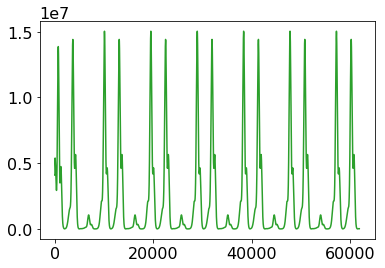

In [0]:
plt.plot(m.xjerk**2 + m.yjerk**2)
